In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf

In [31]:
def getData(stocks,start,end):
    data = yf.download(stocks, start=startDate , end=endDate)['Close']
    returns=np.log(data/ data.shift(1))
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [32]:
def portfolioPerformance(weights,meanReturns,covMatrix,Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

In [33]:
stockList = ['AAPL', 'AMZN', 'MSFT','GLD','JPM','TLT']

In [34]:
stocks = [stock for stock in stockList]

In [35]:
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

In [36]:
startDate

datetime.datetime(2021, 10, 7, 13, 32, 23, 235968)

In [37]:
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)

[*********************100%***********************]  6 of 6 completed


In [38]:
returns = returns.dropna()

In [39]:
returns

,AAPL,AMZN,GLD,JPM,MSFT,TLT
Date,,,,,,
2021-10-08,-0.002725,-0.004191,0.000426,0.000764,0.000000,-0.007023
2021-10-11,-0.000630,-0.012952,-0.001889,-0.021256,-0.002105,-0.002541
2021-10-12,-0.009145,0.000317,0.004504,-0.007711,-0.004599,0.016955
2021-10-13,-0.004249,0.011314,0.017638,-0.026721,0.011643,0.009679
2021-10-14,0.020024,0.004733,0.002443,0.015225,0.021501,0.003709
...,...,...,...,...,...,...
2023-12-11,-0.013012,-0.010433,-0.011104,0.003652,-0.007860,-0.002118
2023-12-12,0.007889,0.010840,-0.000545,0.008886,0.008261,0.002964
2023-12-13,0.016554,0.009179,0.022312,0.003358,-0.000027,0.023191


In [40]:
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)


In [41]:
rmin=0.02
bounds=((0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
def check_minimumReturn(weights):
    RHS = rmin - np.sum(returns.dot(weights.T))
    return RHS
def checksumtoone(weights):
    return np.sum(weights)-1
def Risk_function(weights):
    return np.dot(weights.T,np.dot(covMatrix,weights))
constraints=({'type':'eq','fun':check_minimumReturn},{'type':'eq','fun':checksumtoone})    
w_opt=minimize(Risk_function,weights,method='SLSQP',bounds=bounds,constraints=constraints)

In [42]:
w_opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.00011417829622752797
       x: [ 1.901e-01  1.257e-01  1.567e-01  1.631e-01  1.488e-01
            2.155e-01]
     nit: 2
     jac: [ 3.242e-04  4.553e-04  5.636e-05  1.994e-04  3.330e-04
            8.618e-05]
    nfev: 14
    njev: 2

In [43]:
w_opt.x=weights

In [19]:
from scipy.optimize import minimize

In [44]:
weights

array([0.17546658, 0.13245057, 0.15153128, 0.1661963 , 0.13878349,
       0.23557178])

In [45]:
returns['portfolio'] = returns.dot(weights)

In [47]:
returns['portfolio'].mean()

7.711109544211655e-06

In [48]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

In [49]:
def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [50]:
# 100 days
Time = 100
alphas=[1,2.5,5]
for alpha in alphas:
    hVaR = -historicalVaR(returns['portfolio'], alpha)*np.sqrt(Time)
    hCVaR = -historicalCVaR(returns['portfolio'], alpha)*np.sqrt(Time)
    InitialInvestment = 10000
    print(f'Value at Risk {100-alpha}th CI: {round(InitialInvestment * hVaR, 2)}')
    print(f'Conditional VaR {100-alpha}th CI: {round(InitialInvestment*hCVaR, 2)}')

Value at Risk 99th CI: 2611.86
Conditional VaR 99th CI: 3452.41
Value at Risk 97.5th CI: 2024.11
Conditional VaR 97.5th CI: 2780.29
Value at Risk 95th CI: 1699.97
Conditional VaR 95th CI: 2317.97


In [58]:
Time = 100

In [59]:
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

In [60]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

In [61]:
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [62]:
normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       1728.02
Normal CVaR 95th CI      :       2168.96
t-dist VaR 95th CI       :       1666.55
t-dist CVaR 95th CI      :       2267.58


In [54]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

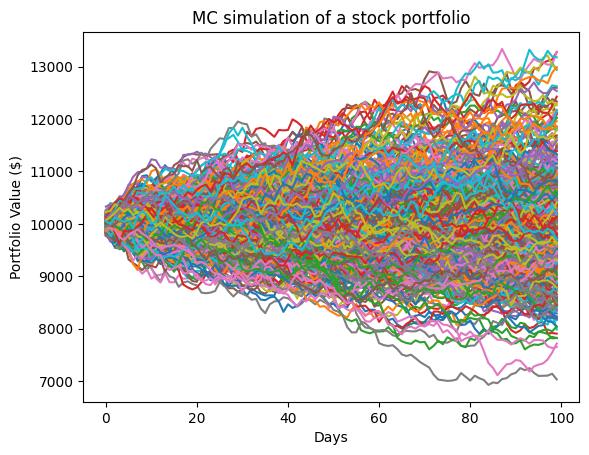

In [55]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()
     

In [56]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [57]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $1611.1
CVaR $1951.78
